In [1]:
# python imports
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline
import astropy as ap
from astropy.io import fits
import matplotlib.pyplot as plt
from astropy.visualization import astropy_mpl_style
plt.style.use(astropy_mpl_style)
import pandas as pd

# lenstronomy imports
from lenstronomy.Util import util
import lenstronomy.Util.image_util as image_util
import lenstronomy.Plots.plot_util as plot_util
from lenstronomy.ImSim.image_model import ImageModel
from lenstronomy.PointSource.point_source import PointSource
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver
from lenstronomy.LightModel.light_model import LightModel
from lenstronomy.Sampling.parameters import Param
from lenstronomy.Data.imaging_data import ImageData
from lenstronomy.Data.psf import PSF
from lenstronomy.Plots.model_plot import ModelPlot
from lenstronomy.Workflow.fitting_sequence import FittingSequence
from lenstronomy.Util import mask_util
from lenstronomy.ImSim.image_linear_solve import ImageLinearFit

In [2]:
# define some useful functions

def get_data(filename, coadd_id):  
    """Input filename and coadd_id returns fwhm of g,r,i bands and image data"""
    hdu_list = fits.open(filename)
    data = pd.DataFrame(hdu_list[2].data) # get dataframe data
    image = hdu_list['IMAGE'].data # get image data
    hdu_list.close() # close
    
    return data, image

def plot_image(image_array):
    fig, ax = plt.subplots()
    ax.imshow(image_array, origin = 'lower')    
    plt.show()
    plt.close()

def add_mask(band, kwargs_data, kwargs_psf):
            """ 
            Input: band (g,r,i), corresponding kwargs_data and kwargs_psf for band
            Output: updated kwargs_data for the band with mask applied
            """
            # apply mask
            data_class = ImageData(**kwargs_data)
            psf_class = PSF(**kwargs_psf)
            imageFit = ImageLinearFit(data_class = data_class, 
                                  psf_class=psf_class,
                                  kwargs_numerics=kwargs_numerics, 
                                  likelihood_mask=mask_2d)
            mask_1d = imageFit.image2array_masked(band)
            masked_image = imageFit.array_masked2image(mask_1d)
            
            # update kwargs_data with masked image
            kwargs_data = {'background_rms': background_rms,  
               'exposure_time': exp_time,  
               'ra_at_xy_0': ra_at_xy_0,  
               'dec_at_xy_0': dec_at_xy_0,  
               'transform_pix2angle': Mpix2coord,  
               'image_data': masked_image}  
            
            return kwargs_data, masked_image

In [3]:
# set filename
filepath = '/Users/gilliancartwright/Desktop/summerproject/' # my personal file path
filename = filepath + 'Quasars.fits'

# show data table for reference
hdu_list = fits.open(filename)
data = pd.DataFrame(hdu_list[2].data)
hdu_list.close()
#print(data.columns) # view all column names
data.head(10)


,NAME,COADD_OBJECT_ID,TILENAME,HPIX_16384,HPIX_4096,DNF_ZMEAN_SOF,RA,DEC,FLUX_RADIUS_G,FLUX_RADIUS_R,...,IMAFLAGS_ISO_I,IMAFLAGS_ISO_Z,FWHM_WMEAN_G,FWHM_WMEAN_R,FWHM_WMEAN_I,FWHM_WMEAN_Z,SKYBRITE_WMEAN_G,SKYBRITE_WMEAN_R,SKYBRITE_WMEAN_I,SKYBRITE_WMEAN_Z
0,DESJ0112-1650,1146879846,DES0112-1707,1098276694,68642293,0.291241,18.141220,-16.840985,3.932359,3.878177,...,0,0,1.058140,0.920101,0.841518,0.787317,414.192993,1118.079956,3729.070068,7356.490234
1,DESJ0501-4118,1532350418,DES0503-4123,2241453493,140090843,0.101100,75.441381,-41.300335,3.099320,3.545753,...,0,0,1.081290,1.027810,0.867825,0.901882,320.069000,927.046997,2752.050049,4901.779785
2,DESJ0245-0556,1330959670,DES0245-0541,2413991670,150874479,0.111465,41.356534,-5.950162,3.055968,2.874859,...,0,0,1.116340,0.952896,0.927758,0.921189,411.776001,1180.140015,2899.929932,8013.839844
3,DESJ0150-4041,1212441684,DES0151-4040,2310061785,144378861,0.221885,27.736982,-40.695591,3.898210,4.267331,...,0,0,1.040950,0.979799,0.924899,0.888690,375.178009,995.431030,3212.100098,8518.379883
4,DESJ2349-4518,1025921566,DES2350-4457,3041123543,190070221,0.578291,357.492430,-45.314703,3.090863,2.935678,...,0,0,1.194170,1.016470,0.880288,0.853919,350.524994,1179.099976,3281.679932,7779.839844
5,DESJ0053-2012,1112574265,DES0054-1958,1097005026,68562814,0.281026,13.435369,-20.209280,3.177962,3.091353,...,0,0,0.961043,0.893971,0.906943,0.818007,425.548004,1079.760010,3087.939941,7383.299805
6,DESJ0600-4649,1596823754,DES0600-4706,2592244634,162015289,0.687135,90.124273,-46.816784,3.107268,2.793631,...,0,0,1.116370,0.948714,0.867564,0.842476,376.791992,988.254028,3297.439941,6159.589844
7,DESJ0246-1845,1331771342,DES0246-1832,2388525430,149282839,1.822159,41.551028,-18.751365,3.343046,2.975646,...,0,0,1.195220,1.014710,0.921888,0.813008,425.429993,1041.430054,2953.820068,8456.799805
8,DESJ0340-2545,1406996169,DES0340-2541,2367950868,147996929,0.101100,55.035151,-25.760991,3.711554,3.677533,...,0,0,1.176360,0.950206,0.893435,0.949142,361.473999,1013.770020,3099.550049,8957.809570
9,DESJ0407-1931,1456100148,DES0406-1915,2371528735,148220545,0.237287,61.974158,-19.522548,4.376297,4.108721,...,0,0,1.126060,0.980889,0.916621,0.850487,384.920013,1001.849976,3119.899902,6937.060059


In [4]:
# Data Specifics for DES camera
background_rms = 7.  # background noise per pixel 
exp_time = 90.  # exposure time 
numPix = 46  # cutout pixel size per axis
deltaPix = 0.2637  # pixel size in arcsec
psf_type = 'GAUSSIAN'

In [13]:
### MODEL
def model(coadd_id, kwargs_lens_initial, kwargs_lens_light_initial, #kwargs_source_initial,#BREAK
          x_images, y_images, mask_list):
    """ 
    INPUT: coadd_id of image, initial lens model and light parameters, 
    list of x coords and y coords of images, 
    OPTIONAL: mask
    
    OUTPUT: RGB image, observed image, reconstructed image, residuals plot, 
    and results of PSO and MCMC fitting
    
    """
    ## Image data
    data, image = get_data(filename, coadd_id)
    row = data[data['COADD_OBJECT_ID'] == coadd_id].index[0]

    g = image[row,0,:,:]
    r = image[row,1,:,:]
    i = image[row,2,:,:]
    
    fwhm_g = data.iloc[row,27]
    fwhm_r = data.iloc[row,28]
    fwhm_i = data.iloc[row,29] 
    
    # set models to use
    lens_model_list = ['SIE', 'SHEAR']
    #source_model_list = ['SERSIC_ELLIPSE'] # BREAK
    lens_light_model_list = ['SERSIC_ELLIPSE']
    
    # generate the coordinate grid and image properties
    ra_grid, dec_grid, ra_at_xy_0, dec_at_xy_0, _, _, Mpix2coord, _ = util.make_grid_with_coordtransform(numPix=numPix, deltapix=deltaPix, center_ra=0, center_dec=0, subgrid_res=1, inverse=False)
    
    # generate image data for each band
    kwargs_data_g = {'background_rms': background_rms,  
               'exposure_time': exp_time,  
               'ra_at_xy_0': ra_at_xy_0,  
               'dec_at_xy_0': dec_at_xy_0,  
               'transform_pix2angle': Mpix2coord,  # translate between pixels and RA, DEC
               'image_data': g}  # 2d data vector of band image
    
    kwargs_data_r = {'background_rms': background_rms,  
               'exposure_time': exp_time,  
               'ra_at_xy_0': ra_at_xy_0,  
               'dec_at_xy_0': dec_at_xy_0,  
               'transform_pix2angle': Mpix2coord,  
               'image_data': r}  
    
    kwargs_data_i = {'background_rms': background_rms,  
               'exposure_time': exp_time,  
               'ra_at_xy_0': ra_at_xy_0,  
               'dec_at_xy_0': dec_at_xy_0,  
               'transform_pix2angle': Mpix2coord, 
               'image_data': i} 
    
    # generate the psf variables for each band
    kwargs_psf_g = {'psf_type': 'GAUSSIAN', 'fwhm': fwhm_g, 'pixel_size': deltaPix, 'truncation': 3}
    kwargs_psf_r = {'psf_type': 'GAUSSIAN', 'fwhm': fwhm_r, 'pixel_size': deltaPix, 'truncation': 3}
    kwargs_psf_i = {'psf_type': 'GAUSSIAN', 'fwhm': fwhm_i, 'pixel_size': deltaPix, 'truncation': 3}
     
    # set numerics
    kwargs_numerics = {'supersampling_factor': 1, 'supersampling_convolution': False}    
    
    # Option to add mask(s)
    # Masks must be added to mask_list in the form:
    # mask_list = [{'mask_center_x': _, 'mask_center_y': _, 'mask_radius': _}, ...]
    if mask_list:
        # get 2d grid for ra and dec
        ra_grid_2d, dec_grid_2d = util.array2image(ra_grid), util.array2image(dec_grid)
        
        def add_mask(band, kwargs_data, kwargs_psf):
            """ 
            Input: band (g,r,i), corresponding kwargs_data and kwargs_psf for band
            Output: updated kwargs_data for the band with mask applied
            """
            # apply mask
            data_class = ImageData(**kwargs_data)
            psf_class = PSF(**kwargs_psf)
            imageFit = ImageLinearFit(data_class = data_class, 
                                  psf_class=psf_class,
                                  kwargs_numerics=kwargs_numerics, 
                                  likelihood_mask=mask_2d)
            mask_1d = imageFit.image2array_masked(band)
            masked_image = imageFit.array_masked2image(mask_1d)
            
            # update kwargs_data with masked image
            kwargs_data = {'background_rms': background_rms,  
               'exposure_time': exp_time,  
               'ra_at_xy_0': ra_at_xy_0,  
               'dec_at_xy_0': dec_at_xy_0,  
               'transform_pix2angle': Mpix2coord,  
               'image_data': masked_image}  
            
            return kwargs_data, masked_image
        
        # add each mask from mask_list
        for index in range(len(mask_list)):
            # generate mask
            mask = mask_list[index]
            mask_2d = mask_util.mask_center_2d(center_x=mask.get('mask_center_x'), 
                                               center_y=mask.get('mask_center_y'), 
                                               r=mask.get('mask_radius'), 
                                               x_grid=ra_grid_2d, y_grid=dec_grid_2d)
            # call function to add mask to each band
            kwargs_data_g, g = add_mask(g, kwargs_data_g, kwargs_psf_g)
            kwargs_data_r, r = add_mask(r, kwargs_data_r, kwargs_psf_r)
            kwargs_data_i, i = add_mask(i, kwargs_data_i, kwargs_psf_i)
            
        # plots each band with mask(s) for reference 
        fig, ax = plt.subplots(1, 3, figsize=(16, 8), sharex=False, sharey=False)
        ax[0].imshow(g, origin='lower', cmap='gray', alpha=0.5)
        ax[1].imshow(r, origin='lower', cmap='gray', alpha=0.5)
        ax[2].imshow(i, origin='lower', cmap='gray', alpha=0.5)
        ax[0].text(0,numPix-5, 'G-Band', color="w", backgroundcolor='k', fontsize = 14)
        ax[1].text(0,numPix-5, 'R-Band', color="w", backgroundcolor='k', fontsize = 14)
        ax[2].text(0,numPix-5, 'I-Band', color="w", backgroundcolor='k', fontsize = 14) 
        plt.show()
        plt.close()
        
    elif mask_list == None:
        pass
    else:
        print('Please add mask or set mask_list=None')
    
    ## Settings for model
    # set models: 
    lens_model_list = ['SIE', 'SHEAR'] # SIE profile and external shear
    lens_light_model_list = ['SERSIC_ELLIPSE'] # sersic light profile
    point_source_list = ['LENSED_POSITION'] # input for point source is image positions, not source position
    #source_model_list = ['SERSIC'] #BREAK
        
    # combine models 
    kwargs_model = {'lens_model_list': lens_model_list,
                    'lens_light_model_list': lens_light_model_list,
                    'point_source_model_list': point_source_list,
                    #'source_light_model_list': source_model_list, # BREAK
                    'additional_images_list': [False],
                    'fixed_magnification_list': [False]}  # mag. ratio of point source is not fixed to the one given by lens model 
        
    # tell kwargs_constraints how to solve based on the number of images 
    ps_images = len(x_images) # number of images of the point source
    if ps_images == 4:
        solver_type = 'PROFILE_SHEAR'
    elif ps_images == 3 or ps_images == 1:
        solver_type='NONE'
    elif ps_images == 2: 
        solver_type = 'ELLIPSE'
    else:
        print('INVALID NUMBER OF IMAGES FOR SIE MODEL. CHANGE LENS MODEL OR PS_IMAGES')

    kwargs_constraints = { 'num_point_source_list': [ps_images], 'solver_type': solver_type, 
                         #'joint_source_with_point_source': [[0, 0]] #BREAK
                         }

    kwargs_likelihood = {'check_bounds': True, # punishing factor for image positions
                     'force_no_add_image': False,
                     'source_marg': False,
                     'image_position_uncertainty': 0.004,
                     'check_matched_source_position': True,
                     'source_position_tolerance': 0.001,
                     'source_position_sigma': 0.001
                         } # see lenstronomy_extensions notebook: quad modelling for more info on these

    # Combine bands for modeling
    g_band = [kwargs_data_g, kwargs_psf_g, kwargs_numerics]
    r_band = [kwargs_data_r, kwargs_psf_r, kwargs_numerics]
    i_band = [kwargs_data_i, kwargs_psf_i, kwargs_numerics]
    
    multi_band_list = [g_band, r_band, i_band]
    kwargs_data_joint = {'multi_band_list': multi_band_list, 'multi_band_type': 'multi-linear'}

    ## Add parameters to model:    
    # lens
    kwargs_lens_fixed = [{}, {'ra_0': 0, 'dec_0': 0}]
    kwargs_lens_init = []
    kwargs_lens_sigma = []
    kwargs_lower_lens = []
    kwargs_upper_lens = []

    # lens model
    kwargs_lens_init.append(kwargs_lens_initial) 
    kwargs_lens_sigma.append({'theta_E': 0.3, 'e1': 0.2, 'e2': 0.2, 'center_x': 0.1, 'center_y': 0.1})
    kwargs_lower_lens.append({'theta_E': 0.5, 'e1': -0.5, 'e2': -0.5, 'center_x': -2, 'center_y': -2})
    kwargs_upper_lens.append({'theta_E': 5, 'e1': 0.5, 'e2': 0.5,  'center_x': 2, 'center_y': 2})

    # add shear to lens
    kwargs_lens_init.append({'gamma1': 0, 'gamma2': 0})
    kwargs_lens_sigma.append({'gamma1': 0.1, 'gamma2': 0.1})
    kwargs_lower_lens.append({'gamma1': -0.2, 'gamma2': -0.2})
    kwargs_upper_lens.append({'gamma1': 0.2, 'gamma2': 0.2})

    # lens light
    kwargs_lens_light_fixed = [{}]
    kwargs_lens_light_init = [kwargs_lens_light_initial]
    kwargs_lens_light_sigma = [{'R_sersic': 0.1, 'n_sersic': 0.2, 'e1': 0.1, 'e2': 0.1, 'center_x': .1, 'center_y': 0.1}]
    kwargs_lower_lens_light = [{'R_sersic': 0.05, 'n_sersic': 0.5, 'e1': -0.5, 'e2': -0.5, 'center_x': -2, 'center_y': -2}]
    kwargs_upper_lens_light = [{'R_sersic': 7, 'n_sersic': 4., 'e1': 0.5, 'e2': 0.5, 'center_x': 2, 'center_y': 2}]

    # point source image positions (loose constraints on image positions)
    #kwargs_ps_fixed = [{}]
    #kwargs_ps_init = [kwargs_ps_initial]
    #kwargs_ps_sigma = [{'ra_image': [0.02] * ps_images, 'dec_image': [0.02] * ps_images}]
    #kwargs_lower_ps = [{'ra_image': -10 * np.ones_like(x_image), 'dec_image': -10 * np.ones_like(y_image)}]
    #kwargs_upper_ps = [{'ra_image': 10 * np.ones_like(x_image), 'dec_image': 10 * np.ones_like(y_image)}]
    # point source image positions (tight constraints on image positions)
    kwargs_ps_fixed = [{}]
    kwargs_ps_init = [{'ra_image': x_images, 'dec_image': y_images}]
    kwargs_ps_sigma = [{'ra_image': [0.2] * ps_images, 'dec_image': [0.2] * ps_images}]
    kwargs_lower_ps = [{'ra_image': [i-0.7 for i in x_images], 'dec_image': [i-0.7 for i in y_images]}]
    kwargs_upper_ps = [{'ra_image': [i+0.7 for i in x_images], 'dec_image': [i+0.7 for i in y_images]}]
    
    # source light
    #kwargs_source_fixed = [{}]
    #kwargs_source_init = [kwargs_source_initial]
    #kwargs_source_sigma = [{'R_sersic': 0.1, 'n_sersic': .5, 'center_x': .1, 'center_y': 0.1, 'e1': 0.2, 'e2': 0.2}]
    #kwargs_lower_source = [{'R_sersic': 0.01, 'n_sersic': .5, 'center_x': -2, 'center_y': -2}]
    #kwargs_upper_source = [{'R_sersic': 7, 'n_sersic': 5.,  'center_x': 2, 'center_y': 2}]
    #source_params = [kwargs_source_init, kwargs_source_sigma, kwargs_source_fixed, kwargs_lower_source, kwargs_upper_source]


    # combine params
    lens_params = [kwargs_lens_init, kwargs_lens_sigma, kwargs_lens_fixed, kwargs_lower_lens, kwargs_upper_lens]
    lens_light_params = [kwargs_lens_light_init, kwargs_lens_light_sigma, kwargs_lens_light_fixed, kwargs_lower_lens_light, kwargs_upper_lens_light]
    ps_params = [kwargs_ps_init, kwargs_ps_sigma, kwargs_ps_fixed, kwargs_lower_ps, kwargs_upper_ps]

    kwargs_params = {'lens_model': lens_params,
                    'lens_light_model': lens_light_params,
                    'point_source_model': ps_params, 
                    #'source_model': source_params #BREAK
                    }

    ## Fitting
    fitting_seq = FittingSequence(kwargs_data_joint, kwargs_model, kwargs_constraints, kwargs_likelihood, kwargs_params)

    fitting_kwargs_list = [['PSO', {'sigma_scale': 1., 'n_particles': 100, 'n_iterations': 100}],
                           ['MCMC', {'n_burn': 100, 'n_run': 300, 'walkerRatio': 10, 'sigma_scale': .1}]]

    chain_list = fitting_seq.fit_sequence(fitting_kwargs_list)
    kwargs_result = fitting_seq.best_fit()

    ## Show results
    # plot observed, reconstructed, and residual plots
    modelPlot = ModelPlot(multi_band_list, kwargs_model, kwargs_result, arrow_size=0.02, cmap_string="gist_heat")

    f, axes = plt.subplots(1, 4, figsize=(16, 8), sharex=False, sharey=False)

    # make RGB image 
    rgb_data = ap.visualization.make_lupton_rgb(i, r, g, stretch = 50, Q = 10)
    axes[0].imshow(rgb_data, origin = 'lower')
    axes[0].grid(False)
    axes[0].set_xticks([])
    axes[0].set_yticks([])
    axes[0].text(0,numPix-5, 'RGB Image', color="w", backgroundcolor='k', fontsize = 14)
    
    modelPlot.data_plot(ax=axes[1])
    modelPlot.model_plot(ax=axes[2])
    modelPlot.normalized_residual_plot(ax=axes[3], v_min=-6, v_max=6)
        
    f.tight_layout()
    f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0., hspace=0.05)
    plt.show()
    plt.close()
    # print actual results
    print(kwargs_result)
    print(f"Model Results: theta_E ={round(kwargs_result.get('kwargs_lens')[0].get('theta_E'),2)}")


    

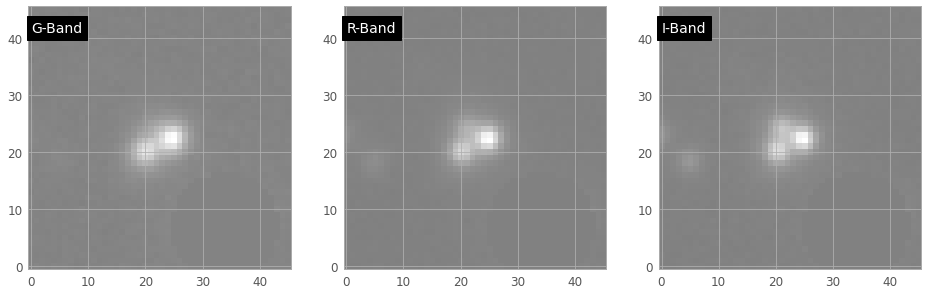

Computing the PSO ...
10
20
30
40
50
60
70
80
90
100
Max iteration reached! Stopping.
-1.199810304943466 reduced X^2 of best position
-3793.8001842312397 logL
6324.0 effective number of data points
[{'theta_E': 1.3799843871800261, 'e1': -0.7383204012247622, 'e2': -0.45983917478181635, 'center_x': -0.7800321340339954, 'center_y': 0.15677383001306824}, {'gamma1': -0.05474924699971704, 'gamma2': -0.13857592132948368, 'ra_0': 0, 'dec_0': 0}] lens result
[] source result
[{'amp': 1, 'R_sersic': 2.562270261348781, 'n_sersic': 3.9999928151959394, 'e1': -0.01858157831621699, 'e2': 0.017028215234010553, 'center_x': -0.32829522601164574, 'center_y': 0.2598493063221118}] lens light result
[{'ra_image': array([-0.59904961,  0.60787371]), 'dec_image': array([-0.7152628 , -0.06466023]), 'point_amp': array([1., 1.])}] point source result
{} special param result
57.47544288635254 time used for  PSO


100%|█████████████████████████████████████████| 400/400 [06:16<00:00,  1.06it/s]


Computing the MCMC...
Number of walkers =  150
Burn-in iterations:  100
Sampling iterations (in current run): 400
376.969220161438 time taken for MCMC sampling
-1.1955232665187534 reduced X^2 of all evaluated imaging data combined.
reduced chi^2 of data  0 =  0.1442775755705224
reduced chi^2 of data  1 =  0.7585966282894376
reduced chi^2 of data  2 =  2.6836955956963005


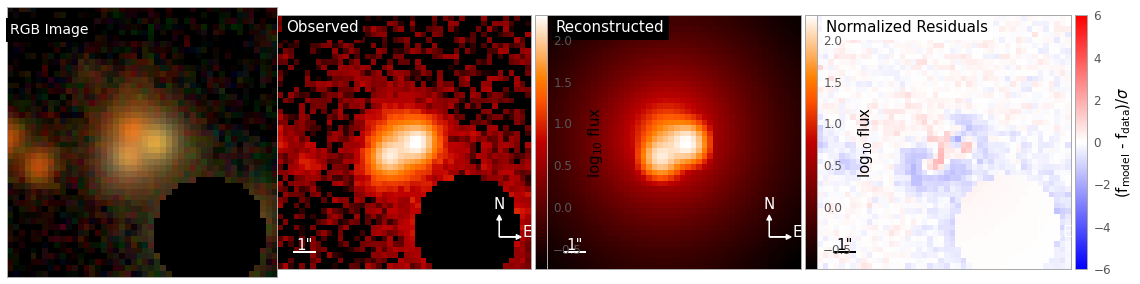

{'kwargs_lens': [{'theta_E': 1.4051179229474, 'e1': -0.7083623970906336, 'e2': -0.1722040931475695, 'center_x': -0.748011115079603, 'center_y': 0.2748761000670842}, {'gamma1': 0.032705177248206346, 'gamma2': -0.057418364754810006, 'ra_0': 0, 'dec_0': 0}], 'kwargs_source': [], 'kwargs_lens_light': [{'amp': 238.0967465152096, 'R_sersic': 2.565698610522761, 'n_sersic': 3.9936982711550537, 'e1': -0.018386320163272594, 'e2': 0.016754864590673314, 'center_x': -0.32880219321573084, 'center_y': 0.2657127385764259}], 'kwargs_ps': [{'ra_image': array([-0.59826316,  0.60785138]), 'dec_image': array([-0.7139788 , -0.06408812]), 'point_amp': array([5197.84025814, 7663.59110434])}], 'kwargs_special': {}, 'kwargs_extinction': []}
Model Results: theta_E =1.41
Actual: theta_E=0.77 +- 0.01


In [14]:
# coadd_id = 1146879846
# lens position
center_x=-0.56
center_y=0.38

# image positions
x_images = [-0.77,0.33]
y_images = [-0.92,-0.16]

# initial guesses for params
kwargs_lens_initial = {'theta_E': 2, 'e1': -0.05, 'e2': 0, 'center_x': center_x, 'center_y': center_y}
kwargs_lens_light_initial= {'R_sersic': 2, 'n_sersic': 2, 'e1': 0, 'e2': 0, 'center_x': center_x, 'center_y': center_y}
# run model
model(coadd_id = 1146879846, 
      kwargs_lens_initial = kwargs_lens_initial, 
      kwargs_lens_light_initial = kwargs_lens_light_initial,
      x_images = x_images, y_images = y_images, 
      mask_list= [{'mask_center_x': 3.03 , 'mask_center_y': -4.09, 'mask_radius':2.5}]
     )

print('Actual: theta_E=0.77 +- 0.01')



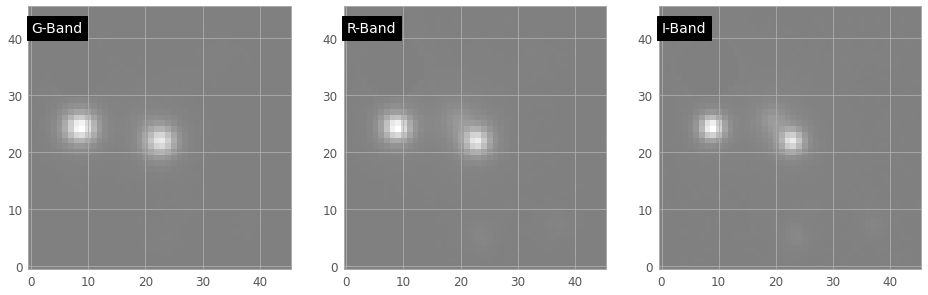

Computing the PSO ...
10
20
30
40
50
60
70
80
90
100
Max iteration reached! Stopping.
-3.9073197578243186 reduced X^2 of best position
-12354.945074240495 logL
6324.0 effective number of data points
[{'theta_E': 2.0592152245495248, 'e1': -0.028913067531735802, 'e2': 0.19437129175980083, 'center_x': -1.0509648228363295, 'center_y': 1.5544535646888298}, {'gamma1': 0.16195868801896757, 'gamma2': 0.12276415983870896, 'ra_0': 0, 'dec_0': 0}] lens result
[] source result
[{'amp': 1, 'R_sersic': 4.55334435374054, 'n_sersic': 3.9976808122921987, 'e1': 0.08932440622918511, 'e2': -0.05715755785538688, 'center_x': -0.7541936915515014, 'center_y': 0.6936788756854609}] lens light result
[{'ra_image': array([ 0.05821302, -3.63834495]), 'dec_image': array([-0.16078149,  0.47390359]), 'point_amp': array([1., 1.])}] point source result
{} special param result
67.71592402458191 time used for  PSO


100%|█████████████████████████████████████████| 400/400 [06:18<00:00,  1.06it/s]


Computing the MCMC...
Number of walkers =  150
Burn-in iterations:  100
Sampling iterations (in current run): 400
380.05427503585815 time taken for MCMC sampling
-3.891855199715987 reduced X^2 of all evaluated imaging data combined.
reduced chi^2 of data  0 =  1.7304567012099996
reduced chi^2 of data  1 =  3.4729643823696565
reduced chi^2 of data  2 =  6.472144515568302


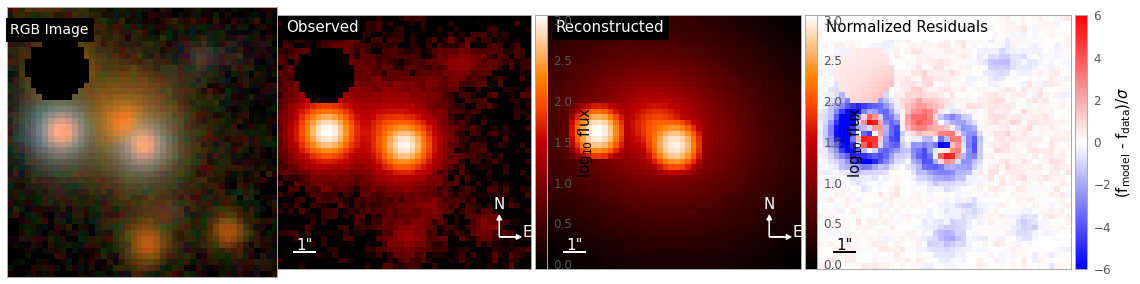

{'kwargs_lens': [{'theta_E': 2.1239164231374446, 'e1': -0.0012874249246453832, 'e2': 0.10921041616200747, 'center_x': -1.0276986079527386, 'center_y': 1.5604157405808952}, {'gamma1': 0.16068207182114008, 'gamma2': 0.10578108279696839, 'ra_0': 0, 'dec_0': 0}], 'kwargs_source': [], 'kwargs_lens_light': [{'amp': 190.07107461994136, 'R_sersic': 4.5361439552285026, 'n_sersic': 3.9965541111071006, 'e1': 0.09562903966767461, 'e2': -0.05652804786369276, 'center_x': -0.7606956278632662, 'center_y': 0.6900816316210923}], 'kwargs_ps': [{'ra_image': array([ 0.0577292 , -3.63853769]), 'dec_image': array([-0.16171904,  0.47372723]), 'point_amp': array([24647.9718647 , 32393.66695079])}], 'kwargs_special': {}, 'kwargs_extinction': []}
Model Results: theta_E =2.12
Actual theta_E: 1.97 +- 0.03


In [15]:
# coadd_id = 1532350418
# lens position
center_x=-1.0
center_y=0.81

# image positions
x_images = [-0.0,-3.7]
y_images = [-0.3,0.3]

# initial guesses for params
kwargs_lens_initial = {'theta_E': 1.5, 'e1': 0., 'e2': 0, 'center_x': center_x, 'center_y': center_y}
kwargs_lens_light_initial= {'R_sersic': 1, 'n_sersic': 2, 'e1': 0, 'e2': 0, 'center_x': center_x, 'center_y': center_y}


# run model
model(coadd_id = 1532350418, 
      kwargs_lens_initial = kwargs_lens_initial, 
      kwargs_lens_light_initial = kwargs_lens_light_initial,
      x_images = x_images, y_images = y_images, 
      mask_list= [{'mask_center_x': -3.8 , 'mask_center_y': 3.2, 'mask_radius':1.4}]
     )
print('Actual theta_E: 1.97 +- 0.03')



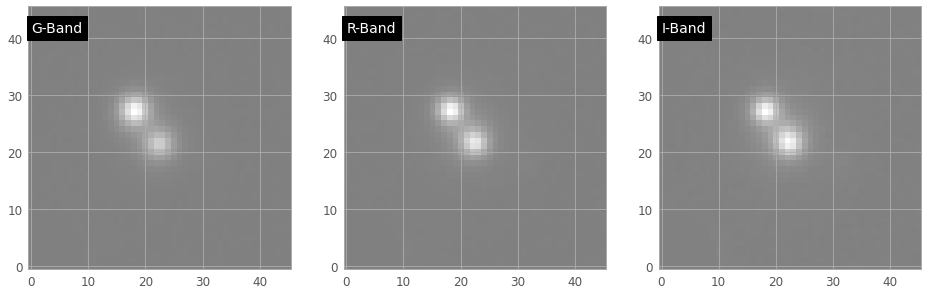

Computing the PSO ...
10
20
30
40
50
60
70
80
90
100
Max iteration reached! Stopping.
-0.6814338777003022 reduced X^2 of best position
-2154.6939212883553 logL
6324.0 effective number of data points
[{'theta_E': 1.6497630410063826, 'e1': -0.5297909024506864, 'e2': -0.3828339134584527, 'center_x': -0.11683726376596713, 'center_y': 0.17132146250223818}, {'gamma1': -0.00505228934231492, 'gamma2': 0.06013721703782539, 'ra_0': 0, 'dec_0': 0}] lens result
[] source result
[{'amp': 1, 'R_sersic': 1.4736098510781006, 'n_sersic': 1.3172683658066044, 'e1': -0.0009693927242978686, 'e2': -0.043710643890534695, 'center_x': -0.34723353755827774, 'center_y': 0.20544194541462027}] lens light result
[{'ra_image': array([-1.14473098, -0.04195494]), 'dec_image': array([ 1.25804951, -0.24517019]), 'point_amp': array([1., 1.])}] point source result
{} special param result
67.39507913589478 time used for  PSO


100%|█████████████████████████████████████████| 400/400 [06:06<00:00,  1.09it/s]


Computing the MCMC...
Number of walkers =  150
Burn-in iterations:  100
Sampling iterations (in current run): 400
367.05136799812317 time taken for MCMC sampling
-0.6788828897479892 reduced X^2 of all evaluated imaging data combined.
reduced chi^2 of data  0 =  0.6662807391330932
reduced chi^2 of data  1 =  0.6083755394067546
reduced chi^2 of data  2 =  0.7619923907041197


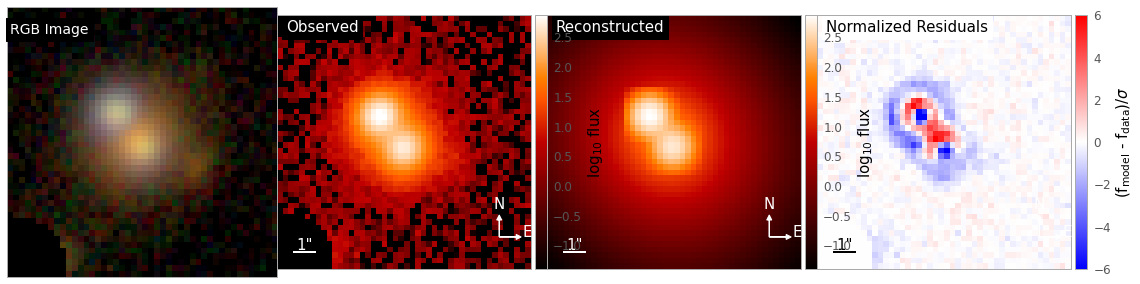

{'kwargs_lens': [{'theta_E': 1.1567615461019978, 'e1': -0.19489317462426187, 'e2': -0.4535975373169468, 'center_x': -0.4189601164959623, 'center_y': 0.18748998964556302}, {'gamma1': -0.12037414817161009, 'gamma2': -0.026764695144483208, 'ra_0': 0, 'dec_0': 0}], 'kwargs_source': [], 'kwargs_lens_light': [{'amp': 1235.0043404996743, 'R_sersic': 1.4734671750353823, 'n_sersic': 1.3258298963759232, 'e1': -0.004967242651048201, 'e2': -0.04138447644486432, 'center_x': -0.34492235614491934, 'center_y': 0.20260053371239273}], 'kwargs_ps': [{'ra_image': array([-1.14558601, -0.04243408]), 'dec_image': array([ 1.25702716, -0.24484995]), 'point_amp': array([14791.50248088, 12898.41322863])}], 'kwargs_special': {}, 'kwargs_extinction': []}
Model Results: theta_E =1.16
Actual theta_E: 0.90 +- 0.02


In [16]:
# coadd_id = 1330959670
# lens position
center_x=-0.18
center_y=-0.08

# image positions
x_images = [-1.4,0.5]
y_images = [1.3,-0.8]

# initial guesses for params
kwargs_lens_initial = {'theta_E': 1.5, 'e1': 0., 'e2': 0, 'center_x': center_x, 'center_y': center_y}
kwargs_lens_light_initial= {'R_sersic': 1, 'n_sersic': 2, 'e1': 0, 'e2': 0, 'center_x': center_x, 'center_y': center_y}


# run model
model(coadd_id = 1330959670, 
      kwargs_lens_initial = kwargs_lens_initial, 
      kwargs_lens_light_initial = kwargs_lens_light_initial,
      x_images = x_images, y_images = y_images, 
      mask_list= [{'mask_center_x':-5.8, 'mask_center_y':-5.8, 'mask_radius':2.5}]
     )
print('Actual theta_E: 0.90 +- 0.02')



Computing the PSO ...
10
20
30
40
50
60
70
80
90
100
Max iteration reached! Stopping.
-0.7279413079646982 reduced X^2 of best position
-2301.750415784376 logL
6324.0 effective number of data points
[{'theta_E': 2.7697025196173377, 'e1': -0.1030394667836083, 'e2': 0.8433819489360833, 'center_x': 0.12984476876246104, 'center_y': -0.36928402354495593}, {'gamma1': 0.022892770416008252, 'gamma2': 0.102663696076467, 'ra_0': 0, 'dec_0': 0}] lens result
[] source result
[{'amp': 1, 'R_sersic': 1.7809258566010617, 'n_sersic': 2.352056247175383, 'e1': 0.10647544136878465, 'e2': 0.001758011951171471, 'center_x': -0.14846027208858842, 'center_y': 0.08187122101573806}] lens light result
[{'ra_image': array([-2.21216648,  0.53939178]), 'dec_image': array([0.0751003 , 0.11836224]), 'point_amp': array([1., 1.])}] point source result
{} special param result
64.69915533065796 time used for  PSO


100%|█████████████████████████████████████████| 400/400 [08:44<00:00,  1.31s/it]


Computing the MCMC...
Number of walkers =  150
Burn-in iterations:  100
Sampling iterations (in current run): 400
525.8009059429169 time taken for MCMC sampling
-0.7224912615079149 reduced X^2 of all evaluated imaging data combined.
reduced chi^2 of data  0 =  0.4991440248812535
reduced chi^2 of data  1 =  0.5609899633396295
reduced chi^2 of data  2 =  1.1073397963028615


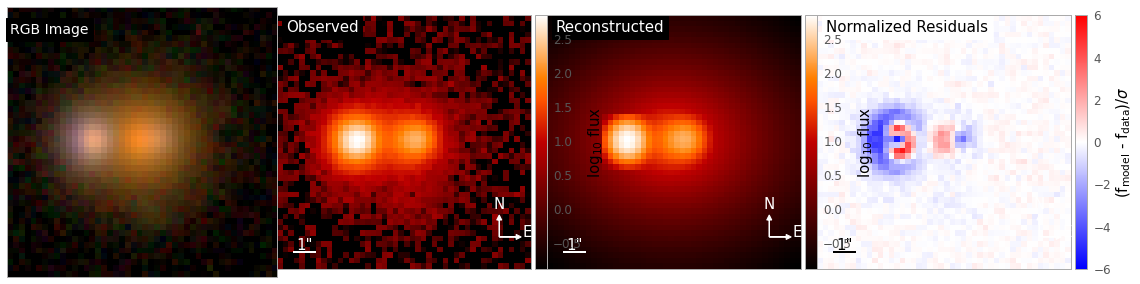

{'kwargs_lens': [{'theta_E': 2.927665526674546, 'e1': 0.32605040084755055, 'e2': 0.6320755380278753, 'center_x': -0.07308605443740375, 'center_y': -0.5131046391598247}, {'gamma1': 0.030815547283534105, 'gamma2': -0.09700589153687822, 'ra_0': 0, 'dec_0': 0}], 'kwargs_source': [], 'kwargs_lens_light': [{'amp': 871.9349653855023, 'R_sersic': 1.7561112560276033, 'n_sersic': 2.228724153645168, 'e1': 0.11543073344665286, 'e2': -0.0013912420134803804, 'center_x': -0.15435062554691217, 'center_y': 0.08209338986500828}], 'kwargs_ps': [{'ra_image': array([-2.21211366,  0.51766898]), 'dec_image': array([0.07429439, 0.12444448]), 'point_amp': array([18942.57413838,  4665.52203167])}], 'kwargs_special': {}, 'kwargs_extinction': []}
Model Results: theta_E =2.93
Actual theta_E: 1.44 +- 0.02


In [17]:
# coadd_id = 1212441684
# lens position
center_x=-0.2
center_y=-0.1

# image positions
x_images = [-2.4,1.0]
y_images = [0.0,0.0]

# initial guesses for params
kwargs_lens_initial = {'theta_E': 1, 'e1': 0., 'e2': 0, 'center_x': center_x, 'center_y': center_y}
kwargs_lens_light_initial= {'R_sersic': 3, 'n_sersic': 4, 'e1': 0, 'e2': 0, 'center_x': center_x, 'center_y': center_y}

# run model
model(coadd_id = 1212441684, 
      kwargs_lens_initial = kwargs_lens_initial, 
      kwargs_lens_light_initial = kwargs_lens_light_initial,
      x_images = x_images, y_images = y_images, 
      mask_list= None)
print('Actual theta_E: 1.44 +- 0.02')



Computing the PSO ...
10
20
30
40
50
60
70
80
90
100
Max iteration reached! Stopping.
-10.295665538206674 reduced X^2 of best position
-32554.894431809502 logL
6324.0 effective number of data points
[{'theta_E': 3.184660777708078, 'e1': -0.7267082150859595, 'e2': -0.6316559920940965, 'center_x': 1.1045501589602882, 'center_y': 1.2961443937052166}, {'gamma1': 0.029002685796254063, 'gamma2': 0.16946112208571754, 'ra_0': 0, 'dec_0': 0}] lens result
[] source result
[{'amp': 1, 'R_sersic': 0.6756520211698326, 'n_sersic': 3.9964010124836435, 'e1': 0.3112273712884863, 'e2': -0.05737688713436959, 'center_x': -1.9999973605208792, 'center_y': 0.07589581470810523}] lens light result
[{'ra_image': array([0.24317582, 1.40201449]), 'dec_image': array([0.07292683, 0.25662729]), 'point_amp': array([1., 1.])}] point source result
{} special param result
61.61889410018921 time used for  PSO


100%|█████████████████████████████████████████| 400/400 [08:17<00:00,  1.24s/it]
/Users/gilliancartwright/miniconda3/lib/python3.9/site-packages/lenstronomy/Plots/model_band_plot.py:43: RuntimeWarning: divide by zero encountered in log10
  log_model = np.log10(model)
/Users/gilliancartwright/miniconda3/lib/python3.9/site-packages/lenstronomy/Plots/model_band_plot.py:136: RuntimeWarning: divide by zero encountered in log10
  im = ax.matshow(np.log10(self._model), origin='lower', vmin=v_min, vmax=v_max,


Computing the MCMC...
Number of walkers =  150
Burn-in iterations:  100
Sampling iterations (in current run): 400
498.4742786884308 time taken for MCMC sampling
-8.791963706635324 reduced X^2 of all evaluated imaging data combined.
reduced chi^2 of data  0 =  2.504596290494097
reduced chi^2 of data  1 =  6.311741354922788
reduced chi^2 of data  2 =  17.55955347448909


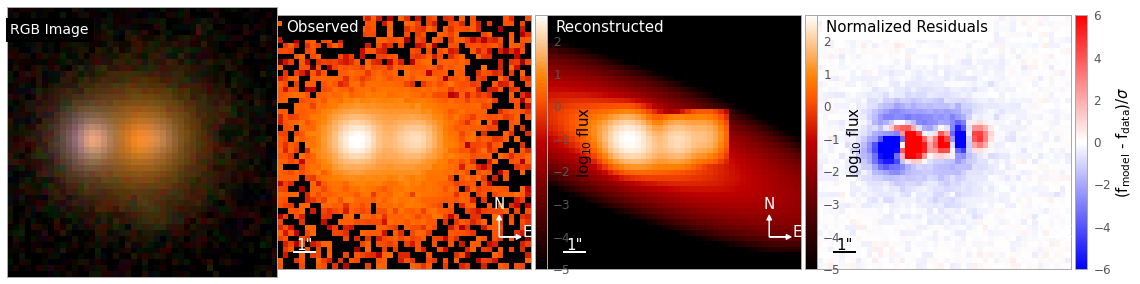

{'kwargs_lens': [{'theta_E': 3.0439710938113014, 'e1': -0.7525810688412186, 'e2': -0.5946089834834013, 'center_x': 1.1731021608235828, 'center_y': 1.0110659698552076}, {'gamma1': -0.12825003238138977, 'gamma2': 0.15476313117035903, 'ra_0': 0, 'dec_0': 0}], 'kwargs_source': [], 'kwargs_lens_light': [{'amp': 1041661.0605176184, 'R_sersic': 0.05014159652219727, 'n_sersic': 3.969636871825246, 'e1': 0.49772817180794815, 'e2': -0.4290387738794245, 'center_x': -1.999992029546918, 'center_y': 0.04937635089953946}], 'kwargs_ps': [{'ra_image': array([0.1920336 , 1.40015084]), 'dec_image': array([0.06212235, 0.23176727]), 'point_amp': array([13203.18843406,  2870.93094631])}], 'kwargs_special': {}, 'kwargs_extinction': []}
Model Results: theta_E =3.04
Actual theta_E: 1.24 +- 0.02


In [18]:
# coadd_id = 1025921566
# lens position
center_x=1.5
center_y=0.2

# image positions
x_images = [-0.3,2.1]
y_images = [-0.3,0.2]

# initial guesses for params
kwargs_lens_initial = {'theta_E': 1.5, 'e1': 0., 'e2': 0, 'center_x': center_x, 'center_y': center_y}
kwargs_lens_light_initial= {'R_sersic': 1, 'n_sersic': 0.5, 'e1': 0, 'e2': 0, 'center_x': center_x, 'center_y': center_y}


# run model
model(coadd_id = 1212441684, 
      kwargs_lens_initial = kwargs_lens_initial, 
      kwargs_lens_light_initial = kwargs_lens_light_initial,
      x_images = x_images, y_images = y_images, 
      mask_list= None)
print('Actual theta_E: 1.24 +- 0.02')



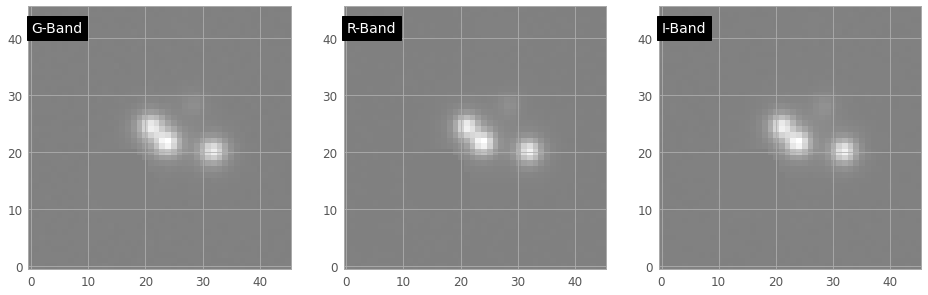

Computing the PSO ...
10
20
30
40
50
60
70
80
90
100
Max iteration reached! Stopping.
-1.0648061250681482 reduced X^2 of best position
-3363.190146027746 logL
6317.0 effective number of data points
[{'theta_E': 1.3898521822754557, 'e1': -0.12403666822200776, 'e2': 0.29428946007053913, 'center_x': 1.3529105786397526, 'center_y': 1.0182200776444863}, {'gamma1': 0.15073708350686757, 'gamma2': -0.09961686818102905, 'ra_0': 0, 'dec_0': 0}] lens result
[] source result
[{'amp': 1, 'R_sersic': 3.124086282261177, 'n_sersic': 2.799494006781683, 'e1': 0.1868201598909632, 'e2': -0.15215235902400778, 'center_x': 0.7088198899918996, 'center_y': -0.003767976968700096}] lens light result
[{'ra_image': array([-0.41526432,  0.3221661 ,  1.5321964 ,  2.46528741]), 'dec_image': array([ 0.51617979, -0.24471463,  1.42430435, -0.61912837]), 'point_amp': array([1., 1., 1., 1.])}] point source result
{} special param result
143.93950390815735 time used for  PSO


100%|█████████████████████████████████████████| 400/400 [10:41<00:00,  1.60s/it]


Computing the MCMC...
Number of walkers =  160
Burn-in iterations:  100
Sampling iterations (in current run): 400
642.8091289997101 time taken for MCMC sampling
-0.8232925711678517 reduced X^2 of all evaluated imaging data combined.
reduced chi^2 of data  0 =  0.260061838070911
reduced chi^2 of data  1 =  0.9746869995690959
reduced chi^2 of data  2 =  1.2351288758635484


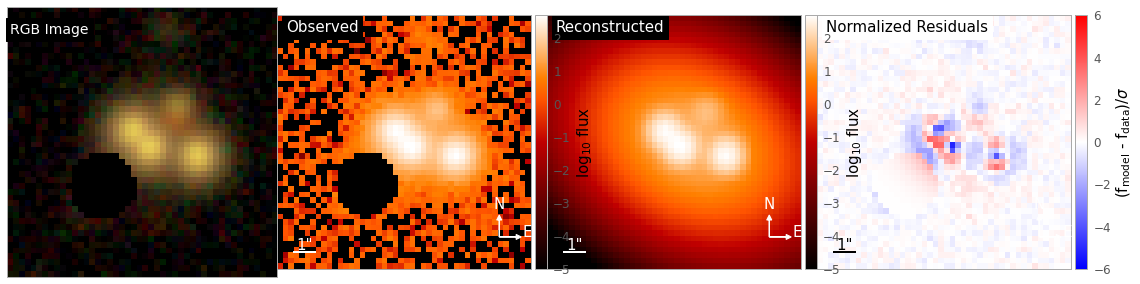

{'kwargs_lens': [{'theta_E': 1.41460690440701, 'e1': -0.13208883595441256, 'e2': 0.32588157161797204, 'center_x': 1.4012048553590515, 'center_y': 1.1007018251432863}, {'gamma1': 0.1573288740335286, 'gamma2': -0.09298362187349099, 'ra_0': 0, 'dec_0': 0}], 'kwargs_source': [], 'kwargs_lens_light': [{'amp': 780.9215804571548, 'R_sersic': 1.6123905544108237, 'n_sersic': 0.556758471509166, 'e1': 0.09039854274451772, 'e2': -0.13194276912118533, 'center_x': 0.8772330230094989, 'center_y': -0.025854058306436792}], 'kwargs_ps': [{'ra_image': array([-0.4221381 ,  0.32428083,  1.55320029,  2.46978317]), 'dec_image': array([ 0.5063836 , -0.22860697,  1.43405177, -0.62370457]), 'point_amp': array([15005.45437613, 17338.1701013 ,  1926.34384813, 15415.14686502])}], 'kwargs_special': {}, 'kwargs_extinction': []}
Model Results: theta_E =1.41
Actual theta_E: 1.17 +- 0.01


In [19]:
# coadd_id = 1112574265
# lens position
center_x=1.4
center_y=0.8

# image positions
x_images = [-0.6,0.1,1.4,2.4]
y_images = [0.4,-0.4,1.5,-0.7]

# initial guesses for params
kwargs_lens_initial = {'theta_E': 1.5, 'e1': 0., 'e2': 0, 'center_x': center_x, 'center_y': center_y}
kwargs_lens_light_initial= {'R_sersic': 1, 'n_sersic': 3, 'e1': 0, 'e2': 0, 'center_x': center_x, 'center_y': center_y}



# run model
model(coadd_id = 1112574265, 
      kwargs_lens_initial = kwargs_lens_initial, 
      kwargs_lens_light_initial = kwargs_lens_light_initial,
      x_images = x_images, y_images = y_images, 
      mask_list= [{'mask_center_x': -1.8 , 'mask_center_y': -2.0, 'mask_radius':1.5}]
     )
print('Actual theta_E: 1.17 +- 0.01')



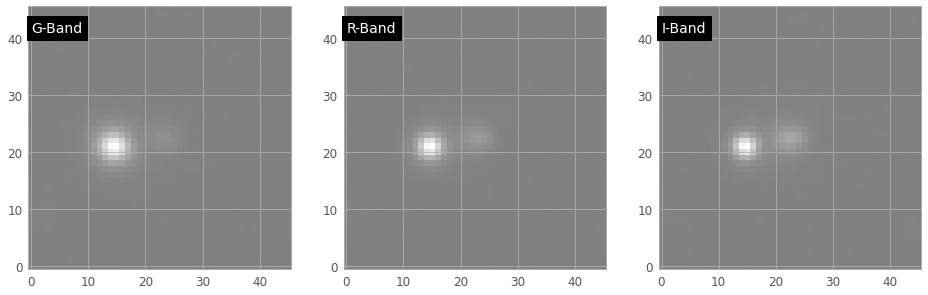

Computing the PSO ...
10
20
30
40
50
60
70
80
90
100
Max iteration reached! Stopping.
-0.7104939096337028 reduced X^2 of best position
-2246.5817422617683 logL
6324.0 effective number of data points
[{'theta_E': 1.3858817654441098, 'e1': -0.2434449282470314, 'e2': -0.6783675332407416, 'center_x': -0.2761501123261171, 'center_y': 0.17754320006378418}, {'gamma1': -0.06156843749188778, 'gamma2': -0.09110790581791454, 'ra_0': 0, 'dec_0': 0}] lens result
[] source result
[{'amp': 1, 'R_sersic': 1.406719795601578, 'n_sersic': 0.54526940785596, 'e1': 0.20414008606092812, 'e2': 0.06948633394264413, 'center_x': -0.9457169540798863, 'center_y': -0.1512897681468119}] lens light result
[{'ra_image': array([-2.08839276,  0.01097308]), 'dec_image': array([-0.41339165, -0.0427399 ]), 'point_amp': array([1., 1.])}] point source result
{} special param result
72.19405889511108 time used for  PSO


100%|█████████████████████████████████████████| 400/400 [07:10<00:00,  1.08s/it]


Computing the MCMC...
Number of walkers =  150
Burn-in iterations:  100
Sampling iterations (in current run): 400
431.87287306785583 time taken for MCMC sampling
-0.708068380603503 reduced X^2 of all evaluated imaging data combined.
reduced chi^2 of data  0 =  0.3648325167140545
reduced chi^2 of data  1 =  0.5290746233070965
reduced chi^2 of data  2 =  1.2302980017893579


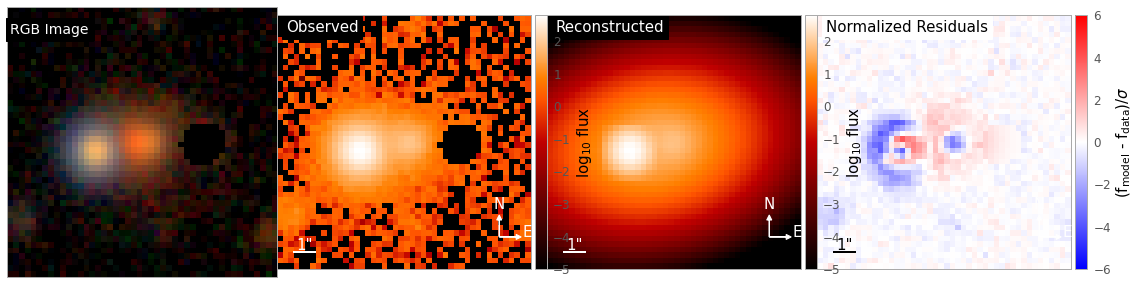

{'kwargs_lens': [{'theta_E': 1.4015302770019304, 'e1': -0.3175412732995852, 'e2': -0.6705187427520364, 'center_x': -0.2814318823221135, 'center_y': 0.19218832778131553}, {'gamma1': -0.08109905396005937, 'gamma2': -0.08447368775987546, 'ra_0': 0, 'dec_0': 0}], 'kwargs_source': [], 'kwargs_lens_light': [{'amp': 917.0785600577782, 'R_sersic': 1.4128492878714258, 'n_sersic': 0.5377983189936018, 'e1': 0.2085305735176637, 'e2': 0.07147110973705847, 'center_x': -0.9480157463196903, 'center_y': -0.14551017550487744}], 'kwargs_ps': [{'ra_image': array([-2.08804043,  0.00942998]), 'dec_image': array([-0.41378644, -0.04399335]), 'point_amp': array([18933.0620185 ,  6159.83272955])}], 'kwargs_special': {}, 'kwargs_extinction': []}
Model Results: theta_E =1.4
Actual theta_E: 1.22 +- 0.02


In [20]:
# 1596823754
# lens position
center_x=-0.3
center_y=-0.1

# image positions
x_images = [-2.3,0.5]
y_images = [-0.5,0.0]

# initial guesses for params
kwargs_lens_initial = {'theta_E': 1.5, 'e1': 0., 'e2': 0, 'center_x': center_x, 'center_y': center_y}
kwargs_lens_light_initial= {'R_sersic': 1, 'n_sersic': 2, 'e1': 0, 'e2': 0, 'center_x': center_x, 'center_y': center_y}

# run model
model(coadd_id = 1596823754, 
      kwargs_lens_initial = kwargs_lens_initial, 
      kwargs_lens_light_initial = kwargs_lens_light_initial,
      x_images = x_images, y_images = y_images, 
      mask_list= [{'mask_center_x': 2.7 , 'mask_center_y': -0.1, 'mask_radius':1}])
print('Actual theta_E: 1.22 +- 0.02')



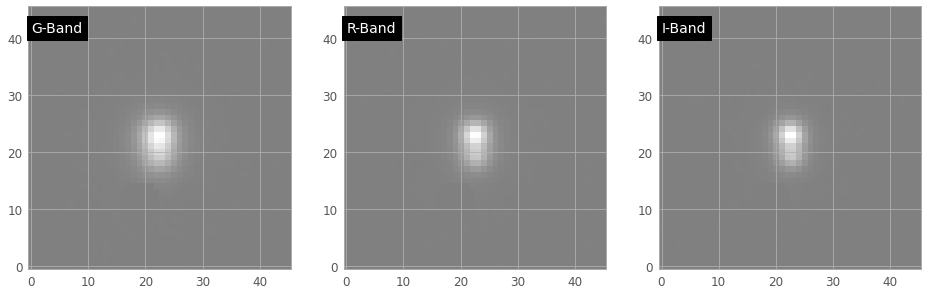

Computing the PSO ...
10
20
30
40
50
60
70
80
90
100
Max iteration reached! Stopping.
-1.0493675474377298 reduced X^2 of best position
-3318.100184998101 logL
6324.0 effective number of data points
[{'theta_E': 0.8675891015359035, 'e1': 0.10615412417668194, 'e2': -0.6926828635991937, 'center_x': -0.17979292615142745, 'center_y': -0.7486886259073467}, {'gamma1': -0.16847901841036914, 'gamma2': 0.12754235791297308, 'ra_0': 0, 'dec_0': 0}] lens result
[] source result
[{'amp': 1, 'R_sersic': 1.1979619335669758, 'n_sersic': 0.5120881317173982, 'e1': -0.05016823985953283, 'e2': -0.007360703919906375, 'center_x': -0.1819829970360814, 'center_y': -0.19856979635839023}] lens light result
[{'ra_image': array([-0.01147767,  0.02647303]), 'dec_image': array([ 0.1340322 , -0.87081142]), 'point_amp': array([1., 1.])}] point source result
{} special param result
71.98771023750305 time used for  PSO


100%|█████████████████████████████████████████| 400/400 [07:16<00:00,  1.09s/it]


Computing the MCMC...
Number of walkers =  150
Burn-in iterations:  100
Sampling iterations (in current run): 400
437.9903790950775 time taken for MCMC sampling
-1.0393241632273218 reduced X^2 of all evaluated imaging data combined.
reduced chi^2 of data  0 =  0.7626934231733049
reduced chi^2 of data  1 =  1.0560815660477907
reduced chi^2 of data  2 =  1.2991975004608702


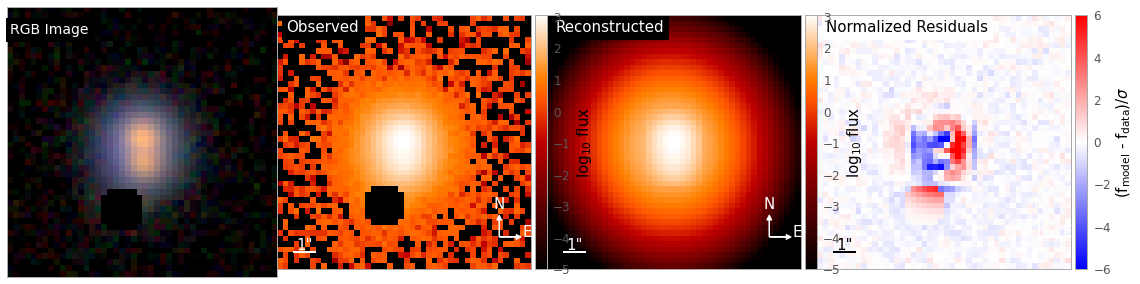

{'kwargs_lens': [{'theta_E': 0.8051467187638675, 'e1': 0.27050651233125095, 'e2': -0.7011011879007573, 'center_x': -0.19537917106398006, 'center_y': -0.746523340321303}, {'gamma1': -0.1982918346291314, 'gamma2': 0.07269685460286142, 'ra_0': 0, 'dec_0': 0}], 'kwargs_source': [], 'kwargs_lens_light': [{'amp': 1334.7273227648814, 'R_sersic': 1.1996567235769477, 'n_sersic': 0.5005501371398351, 'e1': -0.03418463038821782, 'e2': -0.007377863398633601, 'center_x': -0.16185651583888228, 'center_y': -0.19918934041501157}], 'kwargs_ps': [{'ra_image': array([-0.01107194,  0.02197531]), 'dec_image': array([ 0.13549528, -0.86821632]), 'point_amp': array([32562.13379225, 17443.25753398])}], 'kwargs_special': {}, 'kwargs_extinction': []}
Model Results: theta_E =0.81
Actual theta_E: 0.49 +- 0.01


In [21]:
# 1331771342
# lens position
center_x=-0.2
center_y=-0.7
x_images = [-0.2,-0.1]
y_images = [0.1,-1.1]
kwargs_lens_initial = {'theta_E': 1.5, 'e1': 0., 'e2': 0, 'center_x': center_x, 'center_y': center_y}
kwargs_lens_light_initial= {'R_sersic': 3, 'n_sersic': 4, 'e1': 0, 'e2': 0, 'center_x': center_x, 'center_y': center_y}

# run model
model(coadd_id = 1331771342, 
      kwargs_lens_initial = kwargs_lens_initial, 
      kwargs_lens_light_initial = kwargs_lens_light_initial,
      x_images = x_images, y_images = y_images, 
      mask_list= [{'mask_center_x': -0.9 , 'mask_center_y': -3.0, 'mask_radius':1}])
print('Actual theta_E: 0.49 +- 0.01')

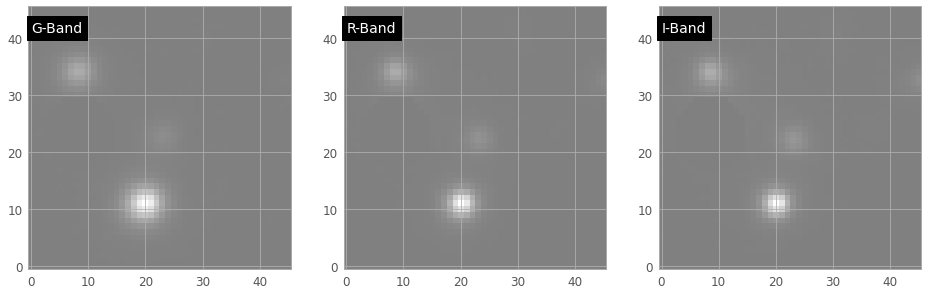

Computing the PSO ...
10
20
30
40
50
60
70
80
90
100
Max iteration reached! Stopping.
-17.051823226826066 reduced X^2 of best position
-53858.183661930125 logL
6317.0 effective number of data points
[{'theta_E': 2.5872071087124295, 'e1': 0.07782216190789093, 'e2': 0.45497038370811044, 'center_x': -0.2169607412281587, 'center_y': -0.27945240073645766}, {'gamma1': -0.1509925527172232, 'gamma2': -0.19657760018992412, 'ra_0': 0, 'dec_0': 0}] lens result
[] source result
[{'amp': 1, 'R_sersic': 0.06127471815686769, 'n_sersic': 2.031626931631722, 'e1': -0.1358966651469067, 'e2': 0.10400056706278664, 'center_x': -0.694086525909588, 'center_y': 0.3720181910241773}] lens light result
[{'ra_image': array([-3.69480786, -0.63779457,  0.39098978]), 'dec_image': array([ 2.96472041, -3.05345908, -0.02831012]), 'point_amp': array([1., 1., 1.])}] point source result
{} special param result
64.4808349609375 time used for  PSO


100%|█████████████████████████████████████████| 400/400 [07:49<00:00,  1.17s/it]


Computing the MCMC...
Number of walkers =  190
Burn-in iterations:  100
Sampling iterations (in current run): 400
470.803115606308 time taken for MCMC sampling
-15.907584550434324 reduced X^2 of all evaluated imaging data combined.
reduced chi^2 of data  0 =  6.441167924772598
reduced chi^2 of data  1 =  12.06358623832902
reduced chi^2 of data  2 =  29.217999488201357


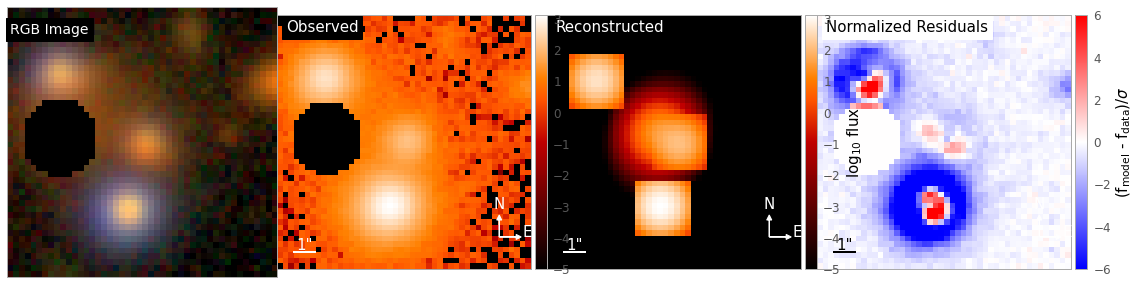

{'kwargs_lens': [{'theta_E': 2.5555374357151073, 'e1': 0.11423314059636312, 'e2': 0.4999364324868297, 'center_x': -0.18733214991488098, 'center_y': -0.24142414785480296}, {'gamma1': -0.15668548113622136, 'gamma2': -0.19990982111708824, 'ra_0': 0, 'dec_0': 0}], 'kwargs_source': [], 'kwargs_lens_light': [{'amp': 31160.759923380567, 'R_sersic': 0.06505922086923872, 'n_sersic': 1.970140861859634, 'e1': -0.1663543898537991, 'e2': 0.14114973562226185, 'center_x': -0.7149464747768833, 'center_y': 0.33328902630795765}], 'kwargs_ps': [{'ra_image': array([-3.68767595, -0.63659046,  0.2434667 ]), 'dec_image': array([ 2.95447648, -3.05211706, -0.05608503]), 'point_amp': array([17343.8528618 , 38523.65759957,  8260.41874561])}], 'kwargs_special': {}, 'kwargs_extinction': []}
Model Results: theta_E =2.56
Actual theta_E: n/a


In [22]:
# 1406996169
# lens position
center_x=-0.1
center_y=-0.3
x_images = [-3.9,-0.8,0.3]
y_images = [3.1,-3.2,0.3]
kwargs_lens_initial = {'theta_E': 1.5, 'e1': 0., 'e2': 0, 'center_x': center_x, 'center_y': center_y}
kwargs_lens_light_initial= {'R_sersic': 1, 'n_sersic':2, 'e1': 0, 'e2': 0, 'center_x': center_x, 'center_y': center_y}

# run model
model(coadd_id = 1406996169, 
      kwargs_lens_initial = kwargs_lens_initial, 
      kwargs_lens_light_initial = kwargs_lens_light_initial,
      x_images = x_images, y_images = y_images, 
      mask_list= [{'mask_center_x': -3.7 , 'mask_center_y': 0.2, 'mask_radius':1.7}])
print('Actual theta_E: n/a')



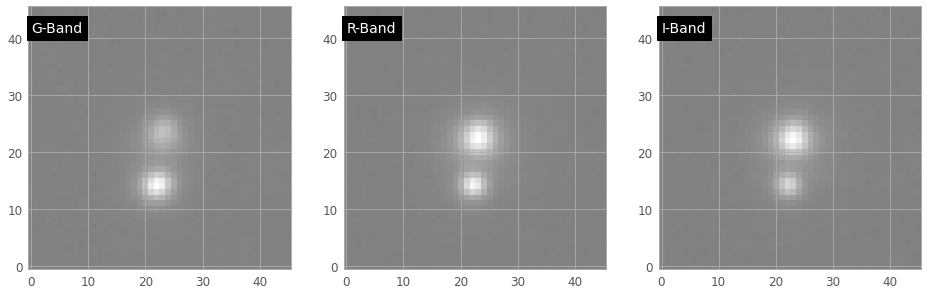

Computing the PSO ...
10
20
30
40
50
60
70
80
90
100
Max iteration reached! Stopping.
-0.3249129552074862 reduced X^2 of best position
-1027.3747643660713 logL
6324.0 effective number of data points
[{'theta_E': 1.514390214092036, 'e1': 0.7922227652080597, 'e2': -0.4652027057369574, 'center_x': 0.1880802050564397, 'center_y': -0.43254347949654265}, {'gamma1': -0.07376019390210825, 'gamma2': -0.08918368929309453, 'ra_0': 0, 'dec_0': 0}] lens result
[] source result
[{'amp': 1, 'R_sersic': 1.2536623304252537, 'n_sersic': 2.435444085593136, 'e1': 0.05627782132114398, 'e2': 0.008109148448409102, 'center_x': 0.10225262240163338, 'center_y': -0.1535113706463433}] lens light result
[{'ra_image': array([-0.08064565,  0.19152818]), 'dec_image': array([-2.18367281,  0.31530369]), 'point_amp': array([1., 1.])}] point source result
{} special param result
70.56778717041016 time used for  PSO


100%|█████████████████████████████████████████| 400/400 [06:47<00:00,  1.02s/it]


Computing the MCMC...
Number of walkers =  150
Burn-in iterations:  100
Sampling iterations (in current run): 400
408.1525020599365 time taken for MCMC sampling
-0.32392050205561357 reduced X^2 of all evaluated imaging data combined.
reduced chi^2 of data  0 =  0.19966918542815631
reduced chi^2 of data  1 =  0.2411393913691369
reduced chi^2 of data  2 =  0.5309529293695474


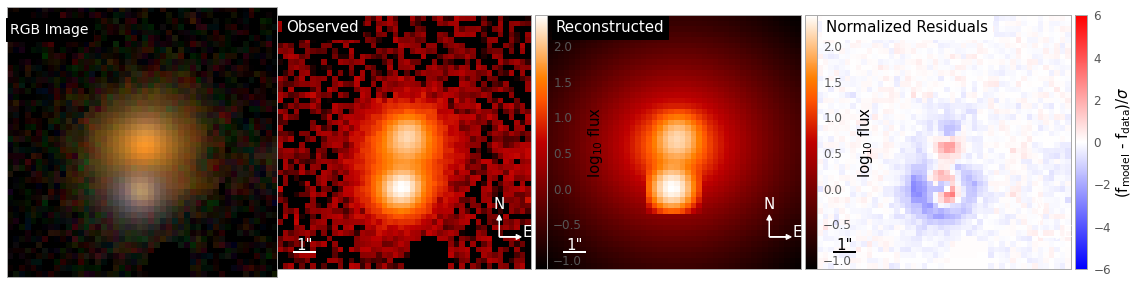

{'kwargs_lens': [{'theta_E': 1.7491871809562325, 'e1': 0.7440493385337837, 'e2': -0.5707795605133401, 'center_x': 0.47358229362213355, 'center_y': -0.5970210979065185}, {'gamma1': -0.02842550612307336, 'gamma2': -0.13861188523053394, 'ra_0': 0, 'dec_0': 0}], 'kwargs_source': [], 'kwargs_lens_light': [{'amp': 1286.2114762937204, 'R_sersic': 1.2596413302100662, 'n_sersic': 2.453604581628648, 'e1': 0.05673560238619846, 'e2': 0.008619404245584, 'center_x': 0.0992469289324365, 'center_y': -0.15781659588936447}], 'kwargs_ps': [{'ra_image': array([-0.08049418,  0.19493586]), 'dec_image': array([-2.18365761,  0.30238902]), 'point_amp': array([6914.97764477, 2016.46041483])}], 'kwargs_special': {}, 'kwargs_extinction': []}
Model Results: theta_E =1.75
Actual theta_E: 1.30 +- 0.02


In [23]:
# 1456100148
# lens position
center_x=-0.1
center_y=-0.3
x_images = [-0.3,-0.0]
y_images = [-2.4,0.8]

# initial guesses for params
kwargs_lens_initial = {'theta_E': 1.5, 'e1': 0., 'e2': 0, 'center_x': center_x, 'center_y': center_y}
kwargs_lens_light_initial= {'R_sersic': 1, 'n_sersic': 2, 'e1': 0, 'e2': 0, 'center_x': center_x, 'center_y': center_y}

# run model
model(coadd_id = 1456100148, 
      kwargs_lens_initial = kwargs_lens_initial, 
      kwargs_lens_light_initial = kwargs_lens_light_initial,
      x_images = x_images, y_images = y_images, 
      mask_list= [{'mask_center_x': 1.2 , 'mask_center_y': -5.5, 'mask_radius':1}])
print('Actual theta_E: 1.30 +- 0.02')

